# Chapter 10: Linear Least Squares


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

%matplotlib inline

## Least Squares Fit
**Correlation Coefficient Flaw**: measure only the strength & sign of a relationship, *but not the slope*.

Methods to Estimate *slope*:
  * **Linear Fit**: a line intended to model the relationship between variables.
  * **Linear Least Squares Fit**: a model of a dataset that *minimizes the sum of squares of the residuals*
    * most common method to *estimate the slope*.
    * A "**least squares**" fit: minimizes the **mean squared error (MSE)** between the line & data
    
### Example
Suppose you have a sequence of points (`ys`), which are expressed as a function of another sequence `xs`.  
If a **linear relationship** between `xs` & `ys` exists with intercept `inter` and slope `m`, we'd expect *each*:  
`y[i] = inter + m * x[i]`

### Residual
Equation:  
**`res = ys - (inter + slope * xs)`**

*Unless the correlation is perfect*, this prediction is only approximate.
  * **Residual**: deviation of an actual value from a model
     * the vertical deviation from the line
     * may be due to random factors (e.g. *measurement error*) or non-random factors (*unknown*)  
        * Non-Random/Unknown Factors of Predicting *weight as a function of height*: diet, exercise, & body type


#### Minimize the Absolute Value of Residuals (*or their squares, cubes,...*)
Most common choice is to *minimize* the **sum of squared residuals**: `sum(res`<sup>2</sup>`))`

Reasons Why (Benefits of Squaring):
  1. Squaring has the feature of *treating positive & negative residuals **the same***.
  2. Squaring gives more weight to large residuals, but not so much weight that the largest residual always dominates.
  3. If the residuals are uncorrelated & normally distributed with mean 0 and constant (but unknown variance), then the **least squares fit** is also the *maximum likelihood estimator* of `inter` and `slope`.
  4. The values of `inter` and `slope` that minimize the squared residuals can be computed efficiently.

## Implementation

In [2]:
def Var(xs, mu=None, ddof=0):
    """Computes variance.

    xs: sequence of values
    mu: option known mean
    ddof: delta degrees of freedom

    returns: float
    """
    xs = np.asarray(xs)

    if mu is None:
        mu = xs.mean()

    ds = xs - mu
    return np.dot(ds, ds) / (len(xs) - ddof)


def MeanVar(xs, ddof=0):
    """Computes mean and variance.

    Based on http://stackoverflow.com/questions/19391149/
    numpy-mean-and-variance-from-single-function

    xs: sequence of values
    ddof: delta degrees of freedom
    
    returns: pair of float, mean and var
    """
    xs = np.asarray(xs)
    mean = xs.mean()
    s2 = Var(xs, mean, ddof)
    return mean, s2


def Cov(xs, ys, meanx=None, meany=None):
    """Computes Cov(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values
        meanx: optional float mean of xs
        meany: optional float mean of ys

    Returns:
        Cov(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)
    
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = np.mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

### Example: NSFG - `agepreg` vs. `totalwgt_lb`
  * **x** (independent var) = mother's age during pregnancy (`agepreg`)
  * **y** (dependent var) = birth weight (`totalwgt_lb`)

In [3]:
import nsfg
preg = nsfg.ReadFemPreg() # DataFrame
live = preg[preg.outcome==1] # filter for live births
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = np.array(live.agepreg)
weights = np.array(live.totalwgt_lb)

In [4]:
yint, slope = LeastSquares(ages, weights)
print "estimated intercept = %.1f lbs and slope = %.3f lbs per year" % (yint, slope)

estimated intercept = 6.8 lbs and slope = 0.017 lbs per year


#### Tip: Interpretation Purposes
**Best Practice**: Present `y-intercept` at the **x<sub>mean</sub>** & transform the `slope` for easier interpretation.
  * Values hard to interpret 
     * `y-intercept` at `x=0` (e.g. intercept is the baby's *expected weight* whose mother is 0 years old)
     * `slope` is too small to grasp easily

In [5]:
intercept_mean = yint + slope * np.mean(ages)
intercept_mean

7.2656284576233681

**Intercept**: easier to interpret if we evaluate `y-intercept` *at the mean of the independent variable*
  * y-int<sub>x-mean</sub> = 7.3 pounds
  * The mean baby weight for a 25 year old mother (mean<sub>`agepreg`</sub>)

In [6]:
slope * 10

0.17453851471802756

**Slope**: easier to interpret if expressed in *pounds per decade* or *ounces per year*.
  * slope = 0.17 lbs/decade
  * The slope is 0.17 pounds per decade

#### Fitted Line
Leverage *estimated* `y-intercept` and `slope` to produce a **fitted line**, which is used to assess:
  * whether the relationship is linear
  * whether the fitted line seems like a good model of the relationship

In [7]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

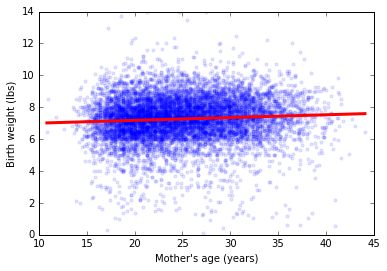

In [8]:
fit_xs, fit_ys = FitLine(ages, yint, slope)

plt.scatter(ages, weights, color='b', alpha=0.1, s=10)
plt.plot(fit_xs, fit_ys, color='r', linewidth=3)
plt.xlabel("Mother's age (years)")
plt.ylabel("Birth weight (lbs)")
plt.xlim([10, 45])
plt.ylim([0, 14])
plt.show()

## Residuals
Another useful test is to plot the residuals
### `Residuals` Function
Takes sequences `xs` and `ys` and estimated parameters `inter` and `slope` to returns the *differences between the **actual values** and the **fitted line***.

In [9]:
def Residuals(xs, ys, inter, slope):
    """Computes residuals for a linear fit with parameters inter and slope.

    Args:
        xs: independent variable
        ys: dependent variable
        inter: float intercept
        slope: float slope

    Returns:
        list of residuals
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res

In [10]:
live['residual'] = Residuals(ages, weights, yint, slope) # difference from fitted line for each actual value

To visualize the residuals:
  1. Split the respondents into groups by `age`.
  2. Plot the *percentiles of the `residuals`* versus the *`average age` in each group*.
  
1) Split respondents into groups by age (13 bins)

In [11]:
bins = np.arange(10,48,3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

age_means = [group.agepreg.mean() for _, group in groups][1:-1]
age_means

[15.212333333333335,
 17.740359281437126,
 20.506304824561404,
 23.455752212389378,
 26.435156146179406,
 29.411177432542924,
 32.302325301204817,
 35.240273631840786,
 38.108764705882351,
 40.912058823529406]

Obtain `25%`, `50%`, `75%` percentiles of each group's residual

In [12]:
perc75 = []
perc50 = []
perc25 = []
for _, group in groups:
    perc75 += [group.residual.describe()['75%']]
    perc50 += [group.residual.describe()['50%']]
    perc25 += [group.residual.describe()['25%']]

2) Plot percentiles of the residuals vs. Average Age per group (`age_means`)

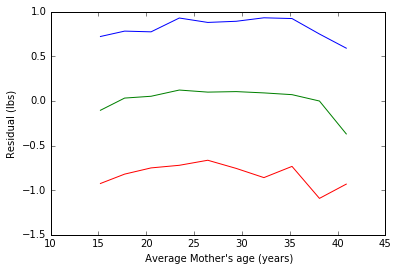

In [13]:
plt.plot(age_means, perc75[1:-1], label= "75th percentile")
plt.plot(age_means, perc50[1:-1], label= "50th percentile")
plt.plot(age_means, perc25[1:-1], label= "25th percentile")
plt.xlabel(" Average Mother's age (years)")
plt.ylabel("Residual (lbs)")
plt.xlim([10, 45])
plt.show()

**Ideal Results**:
  * Flat line plots of residuals, indiciating that *residuals are random*
  * Parallel lines, indicating that the variance of the residuals is the same for all age groups

**Conclusions**
  * Residual plots for the percentiles are *parallel*, but have *some curvature* which **indicates that the relationship is non-linear**.

## Sampling Distribution
To estimate the sampling distribution of `inter` and `slope`.
  * Assess **sampling error** (*result of measuring a sample rather than the entire pop*) by running simulated experiments and computing sampling distributions of the estimates.
    * Answers the question: "*If we run this experiment again, how much variability do we expect in the estimates*?"
  * Parameters `inter` and `slope` are *estimates based on a sample*. Like other estimates, they're vulnerable to sampling bias, measurement error, & sampling error.
  
**Approach**: Resample the data *to estimate parameters `inter` and `slope`.
  
### Estimation of Sampling Distribution *using resampling*

In [14]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame. SampleRows version with resampling.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)

def SamplingDistributions(live, iters=101):
    """Estimates sampling distributions by resampling rows.

    live: DataFrame
    iters: number of times to run simulations

    returns: pair of sequences (estimated inters, estimated slopes)
    """
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

In [15]:
inters, slopes = SamplingDistributions(live, iters=1001)
len(inters), len(slopes)

(1001, 1001)

1001 values for `inters` and `slopes` (*`inter` and `slope` for each estimation*)

#### Summarize
  1. Mean
  2. Standard Deviation/Standard Error
  3. 90% Confidence Interval

#### Confidence Interval: SciPy Package (`scipy.stats.norm.interval()`)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
`scipy.stats.norm.interval(alpha, loc=0, scale=1)1
Parameters:
  * **alpha**: CI endpoints (%)
  * loc = estimate seq's mean
  * scale = estimate seq's std
  
#### Summarize `intercept` resampling estimation

In [16]:
int_ci0, int_ci1 = stats.norm.interval(0.90, loc=np.mean(inters), scale=np.std(inters))
print "Mean = %.2f" % np.mean(inters)
print "Standard Error = %.2f" % np.std(inters)
print "CI = [%.2f, %.2f]" % (int_ci0, int_ci1)

Mean = 6.83
Standard Error = 0.07
CI = [6.71, 6.95]


#### Summarize `slope` resampling estimation

In [17]:
slopes_ci0, slopes_ci1 = stats.norm.interval(0.90, loc=np.mean(slopes), scale=np.std(slopes))
print "Mean = %.3f" % np.mean(slopes)
print "Standard Error = %.3f" % np.std(slopes)
print "CI = [%.3f, %.3f]" % (slopes_ci0, slopes_ci1)

Mean = 0.018
Standard Error = 0.003
CI = [0.013, 0.022]


### Visualizing Uncertainty
To show the uncertainty of the estimated slope and intercept, we can generate a fitted line for each resampled estimate and plot them on top of each other.

Likewise, we can make a more efficient plot by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

**Example**: Shows CI for the fitted values at each mother's age.

In [18]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    import thinkstats2, thinkplot
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)

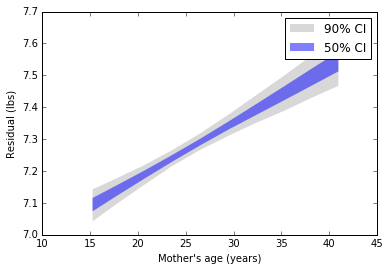

In [19]:
import thinkplot
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='grey', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='blue', alpha=0.5, label='50% CI')
thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

Figure shows the `50%` and `90%` confidence intervals showing variability in the fitted line due to **sampling error** of `inter` and `slope`. The confidence intervals represent the variability of the curves fitted to `birth weight` as a function of `mother's age` (independent var).
  * 90% CI: selects [`5th`, `95th`] percentiles  

The vertical region is *smaller* at values near the mean and *larger* at the extremes.

## Goodness of Fit
**Goodness of Fit**: measures the *quality of a linear model* 
  * a measure of how well a model fits data

Methods:
  1. **Root Mean Squared Error (RMSE)**: standard deviation of residuals
  2. **Coefficient of Determination**

### Standard Deviation of Residuals
`Std(res)` == **RMSE**<sub>predictions</sub>

**Example**:
  1. Use mother's age to guess birth weight:  
    * `RMSE = `**`Std(res)`**
    * **RMSE**<sub>guess</sub> = 1.40 lbs
  2. Guess birth weight *without knowledge of mother's weight*:  
    * `RMSE = `**`Std(ys)`**
    * **RMSE**<sub>guess</sub> = 1.41 lbs

**Note**: Knowing a mother's age does not improve the predictions substantially (residual vs. ys) *for this example*.

In [20]:
live['residual'].std()

1.4049531557176409

In [21]:
live['totalwgt_lb'].std()

1.4082934455690173

### Coefficient of Determination (R<sup>2</sup>)
**Coefficient of Determination**: a statistic intended to quantify goodness of fit
  * The coefficient compares the variance of the `residuals` to the variance of the `dependent variable`.

#### `CoefDetermination` Function
**R<sup>2</sup>** is the fraction of **MSE** that the model *eliminates*.
  * The remaining fraction of MSE that remains (*using the model*) is:
    * `Var(res)` is the **MSE** of your guesses using the model.
    * `Var(ys)` is the **MSE** of your guesses *without the model*.

In [22]:
def CoefDetermination(ys, res):
    """Computes the coefficient of determination (R^2) for given residuals.

    Args:
        ys: dependent variable
        res: residuals
        
    Returns:
        float coefficient of determination
    """
    return 1 - Var(res) / Var(ys)

#### Example: NSFG - `agepreg` vs. `totalwgt_lb`

In [23]:
inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = CoefDetermination(weights, res)
r2

0.0047381154747107024

For birth weight & mother's age, R<sup>2</sup> = 0.0047.
  *  R<sup>2</sup> value indicates that the mother's age predicts about half of 1% variance in birth weight (R<sup>2</sup> * 100)

In other words, **R<sup>2</sup>** is *very small* for birth weight & mother's age, indicating that the mother's age predicts a *small part* of the variance in birth weight.

#### R<sup>2</sup> == *p*<sup>2</sup>
There's a simple relationship between the **Coefficient of Determination** and **Pearson's coefficient of correlation**.

**Example**: If *p*<sup>2</sup> = 0.8 or -0.8, then  R<sup>2</sup> = 0.64

##### Example: NSFG Proof

In [24]:
print 'R-squared = %.5f' % np.sqrt(r2)
print 'p = %.5f' % live[['agepreg', 'totalwgt_lb']].corr(method='pearson').loc[['agepreg'], 
                                                                               ['totalwgt_lb']].values

R-squared = 0.06883
p = 0.06883


### `Std(res)` vs. R<sup>2</sup>
  * **R<sup>2</sup>** & ***p***: best used to quantify strength of relationship, *but not easy to interpret for predictive power*.
  * **`Std(res)`**: best representation of the quality of prediction, *especially if presented i relation to* `Std(ys)`.
  
#### Best Practice: Evaluate Predictive Power
To express **predictive power**, most useful to compare the *standard deviation of residuals* to the *standard deviation of the dependent variable* (`ys`), as a measure (RMSE)
  * if you try to guess birth weight *with* and *without* taking into account mother's age.

In [25]:
print 'Std(ys) = ', np.std(weights)
print 'Std(res) = ', np.std(res)

Std(ys) =  1.40821553384
Std(res) =  1.40487542879


##### Example: SAT Scores & IQ
THe correlation between SAT scores and IQ scores are often discussed when evaluating the validty of SAT scores.

Variables
  * Independent var (`xs`): SAT scores
  * Dependent var (`ys`): IQ
  
According to one study, there's a **Pearson correlation** of *p* = 0.72 between SAT scores & IQ scores, which sounds like a *strong correlation*.
  * But *p*<sup>2</sup> = R<sup>2</sup> = 0.52
    * means that SAT scores only account for 52% of the variance in IQ

In [26]:
# Given, IQ scores are normalized with Std(ys) = 15:
var_ys = 15**2
rho = 0.72 # Pearson correlation
r2 = rho**2
var_res = (1 - r2) * var_ys
std_res = np.sqrt(var_res)
std_res

10.409610943738484

Results:
  * `Std(ys)` = 15
  * `Std(res)`= 10.4  

**Conclusions**:
  * Using SAT score to predict IQ reduces **RMSE** from 15 points to 10.4 points.
  * A correlation of 0.72 yields a reduction in RMSE of only 31%
  
**Note**: If you see an impressive **correlation**, remember that **R<sup>2</sup>** is a *better indicator of reduction in MSE*.
  * Subsequently, reduction in **RMSE** is a better indicator of **predictive power**.

## Testing a Linear Model
#### Approaches
1. Hypothesis test whether the *apparent reduction in MSE* is due to chance.
  * **test statistic**: R<sup>2</sup>
  * **H<sub>0</sub>**: There is no relationship between the variables.
2. Hypothesis test whether the *apparent slope* is due to chance.
  * `Y = B`<sub>0</sub> `+ B`<sub>1</sub>X
    * B<sub>0</sub>: constant
    * B<sub>1</sub>: slope
    * `X`: independent var
    * `Y`: dependent variable
    


### Example: NSFG
The effect of mother's age on birth weight is *small* and has *little predictive power*. Thus, it may be possible that the apparent relationship is due to chance. 
  * Solution: Test results of the linear fit

#### Hypothesis Test: *Apparent Reduction in MSE*
1. Hypothesis
  * **H<sub>0</sub>**: There is no relationship between the variables, `agepreg` and `totalweight_lb`.
  * **H<sub>A</sub>**: There is a relationship between the variables, `agepreg` and `totalweight_lb`.

2. Compute test-statistic & p-value
Simulate the null hypothesis by permutation (Ch 9.5), testing the correlation between the mother's age and birth age. In fact, because R<sup>2</sup> = *p*<sup>2</sup>, a one-sided test of R<sup>2</sup> is equivalent to a two-sided test of *p*.
  * Results: **p < 0.001**
  * **Conclusion:** The apparent relationship between mother's age & birth weight is statistically significant.
  
#### Hypothesis Test : *Apparent Slope*
http://stattrek.com/regression/slope-test.aspx  
Using a Hypothesis Test with slopes, which uses permutation to test whether the observed slope is *statistically significant*.
1. Hypothesis
  * **H<sub>0</sub>**: There slope is actually zero.
    * Model the birth weights as random variations around the mean
  * **H<sub>A</sub>**: There is a slope (*significantly different from zero*).
    * Indicates that there's a significant linear relationship between the independent & dependent variables

2. Compute test statistic & p-value
  * **test statistic**: slope estimated by `LeastSquares` (or linear regression)

In [40]:
m_slope, m_int, m_rval, m_pval, m_stderr = stats.linregress(ages,weights)
print "Observed slope = %.3f lbs/year" % m_slope
print "p-value = %.3f" % m_pval

Observed slope = 0.017 lbs/year
p-value = 0.000


3. Analyze the Results
The **p-value** is extremely small (p-val < 0.001), providing substantial evidence against H<sub>0</sub>. The null hypothesis is *rejected* in favor of H<sub>A</sub>. Thus, although the estimated slope (**t-statistic**) is small, it's unlikely to be due to chance. 

Hence, the slope is different from zero and suggests a *significant linear relationship* between the independent (`agepreg`) and dependent (`totalwgt_lb`) variables.

## Weighted Resampling
### NSFG
NSFG data is not a representative sample; it was deliberately oversampled for several groups to improve the chance of attianing statistically significant results. Ultimately, to improve the power of tests involving these groups.

The survey design is useful for many purposes, but **cannot be used to estimate values for the general population *without accounting for the sampling process***.

### Sampling Weight
**Sampling Weight**: a value associated with an observation in a sample that indicates what part of the population it represents
  * For each respondent, the NSFG data includes a variable `finalwgt` (the number of people in the general population the respondent represents).


### Issue: Oversampling
If you survey 100,000 people in a country of 300 million, each respondent repersents 3,000 people. Oversampling 1 group by a factor of 2, each person in the oversampled group would have a *lower weight* (~1500).

**Solution**: Resampling 
  * draw samples from the survery using **probabilities** proportional to the sampling weights
  * each row is sample with probabilities based on their sampling weight

In [27]:
def ResampleRowsWeighted(df, column='finalwgt'):
    import thinkstats2
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

def Summarize(estimates, actual=None):
    import thinkstats2
    mean = np.mean(estimates)
    stderr = np.std(estimates)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

#### Example: Resampling to Estimate the Mean `birthweight`

##### Without weights

In [28]:
iters = 100
estimates = [ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

('mean, SE, CI', 7.2654940943792887, 0.014750008714823917, (7.2392744523124586, 7.2896658552777165))


#### With weights

In [29]:
estimates = [ResampleRows(live).totalwgt_lb.mean()
             for _ in range(iters)]
Summarize(estimates)

('mean, SE, CI', 7.2658382662093395, 0.015500889803332142, (7.237946724939146, 7.2901291768090282))


##### Results

| | Mean Birth Weight (lbs) | Standard Error | 90% CI |
|:--|:--:|:--:|:--:|
|Unweighted|7.27|0.014|(7.24, 7.29)|
|Weighted|7.35|0.014|(7.32,7.37)|

The difference between resampling *with* and *without* **sampling weights** is non-negligible, suggesting that there are differences in birth weight between the strata in the survey.

In other words, the effect of weighting is small *but non-negligible*. The difference in estimated means, with & without weighting, is ~ 0.08 pounds (1.3 ounces).
  * The difference is substantially larger than the **standard error** of the estimate (0.014 pounds), *implying that the difference is not due to chance*.